In [1]:
%reload_ext watermark
%matplotlib inline

import os
from metapool.metapool import *
from metapool import validate_and_scrub_sample_sheet, make_sample_sheet
%watermark -i -v -iv -m -h -p metapool,sample_sheet,openpyxl -u

Last updated: 2021-12-07T14:57:33.600221-08:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

metapool    : 0+untagged.105.g3747fb8.dirty
sample_sheet: 0.12.0
openpyxl    : 3.0.9

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Hostname: Caitlinss-MacBook-Pro.local

seaborn   : 0.11.2
numpy     : 1.20.3
re        : 2.2.1
pandas    : 1.3.2
matplotlib: 3.4.2



# Knight Lab shotgun pipeline notebook

### What is it?

This Jupyter Notebook allows you to automatically produce most of the files you need for completing the Knight Lab shotgun sequencing pipeline.

Hopefully, this will not only make it much easier to generate these files, but also keep our information more accurate.

### Here's how it should work.

You'll start out with a **basic plate map**, which just links each sample to it's approprite row and column.

Then you'll add the output of the MiniPico assay of sample DNA concentrations, which will enable to you to automatically make a **normalization pick list** for starting the shotgun library prep itself. You can also visualize these concentrations on the plate, allowing you to double check the plate map and DNA concentration read.

Next you'll automatically assign barcodes to each sample, producing an **index pick list** for barcode addition prior to PCR.

After finishing the shotgun library prep itself, you'll measure library concentration with qPCR. This qPCR data file will then be read in and used to estimate and visualize pooling parameters, producing a **pooling pick list**. 

Finally, the per-sample information from the whole run can be combined to automatically produce a **sample sheet** that you can give directly to IGM for sequencing. 

# Workflow for normalizing DNA

This portion of the notebook will read in the output of the mini-Pico quantification assay and construct an Echo normalization picklist file. 

As inputs, it requires:
1. A tab-delimited row-wise plate map that indicates the sample name, well location, and blank status of each sample on the 384 well plate. 

You can use this google sheet template to generate your plate map:
https://docs.google.com/spreadsheets/d/1xPjB6iR3brGeG4bm2un4ISSsTDxFw5yME09bKqz0XNk/edit?usp=sharing

The workflow then:
1. reads in the plate map and constructs a dataframe
2. calculates volumes to be added via echo to reach desired input DNA quantity
3. produces an Echo-formatted pick list file

## Step 1: read in plate map

**Enter the correct path to the plate map file**. This will serve as the plate map for relating all subsequent information.

In [2]:
plate_map_fp = './test_data/Plate_Maps/Finrisk 33-36_plate_map.tsv'

if not os.path.isfile(plate_map_fp):
    print("Problem! %s is not a path to a valid file" % file)

**Read in the plate map**. It should look something like this:

```
Sample	Row	Col	Blank
GLY_01_012	A	1	False
GLY_14_034	B	1	False
GLY_11_007	C	1	False
GLY_28_018	D	1	False
GLY_25_003	E	1	False
GLY_06_106	F	1	False
GLY_07_011	G	1	False
GLY_18_043	H	1	False
GLY_28_004	I	1	False
```
**Make sure there a no duplicate IDs.** If each sample doesn't have a different name, an error will be thrown and you won't be able to generate a sample sheet.

In [3]:
plate_df = read_plate_map_csv(open(plate_map_fp,'r'))

plate_df.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well
0,33-A1,A,1,True,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,A1
1,820072905-2,C,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,C1
2,820029517-3,E,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,E1
3,820073753-4,G,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,G1
4,820049719-1,I,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,I1


## Step 2: read in DNA concentrations and add to plate map

**Enter the correct path to the Pico DNA concentration output**. This should be a csv-formatted file produced by the MiniPico assay on the condensed, 384-well plate. 

In [4]:
sample_concs_fp = './test_data/Quant/MiniPico/FinRisk_33-36_gDNA_quant.tsv'

if not os.path.isfile(sample_concs_fp):
    print("Problem! %s is not a path to a valid file" % file)

**Read in the DNA concentration output file**. It should look something like this:
    
```
Results

Well ID	Well	[Blanked-RFU]	[Concentration]
SPL1	A1	5243.000	3.432
SPL2	C1	4949.000	3.239
SPL3	E1	15302.000	10.016
SPL4	G1	4039.000	2.644
SPL5	I1	12862.000	8.419
SPL6	K1	2840.000	1.859
SPL7	M1	3343.000	2.188
```

In [5]:
sample_concs = read_pico_csv(open(sample_concs_fp,'r'))

plate_df = pd.merge(plate_df, sample_concs, on='Well')

well_col = 'Well'

plate_df.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well,Sample DNA Concentration
0,33-A1,A,1,True,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,A1,0.044
1,820072905-2,C,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,C1,25.654
2,820029517-3,E,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,E1,3.336
3,820073753-4,G,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,G1,1.529
4,820049719-1,I,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,I1,6.705


**Visualize plate DNA concentrations and plate map:**

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


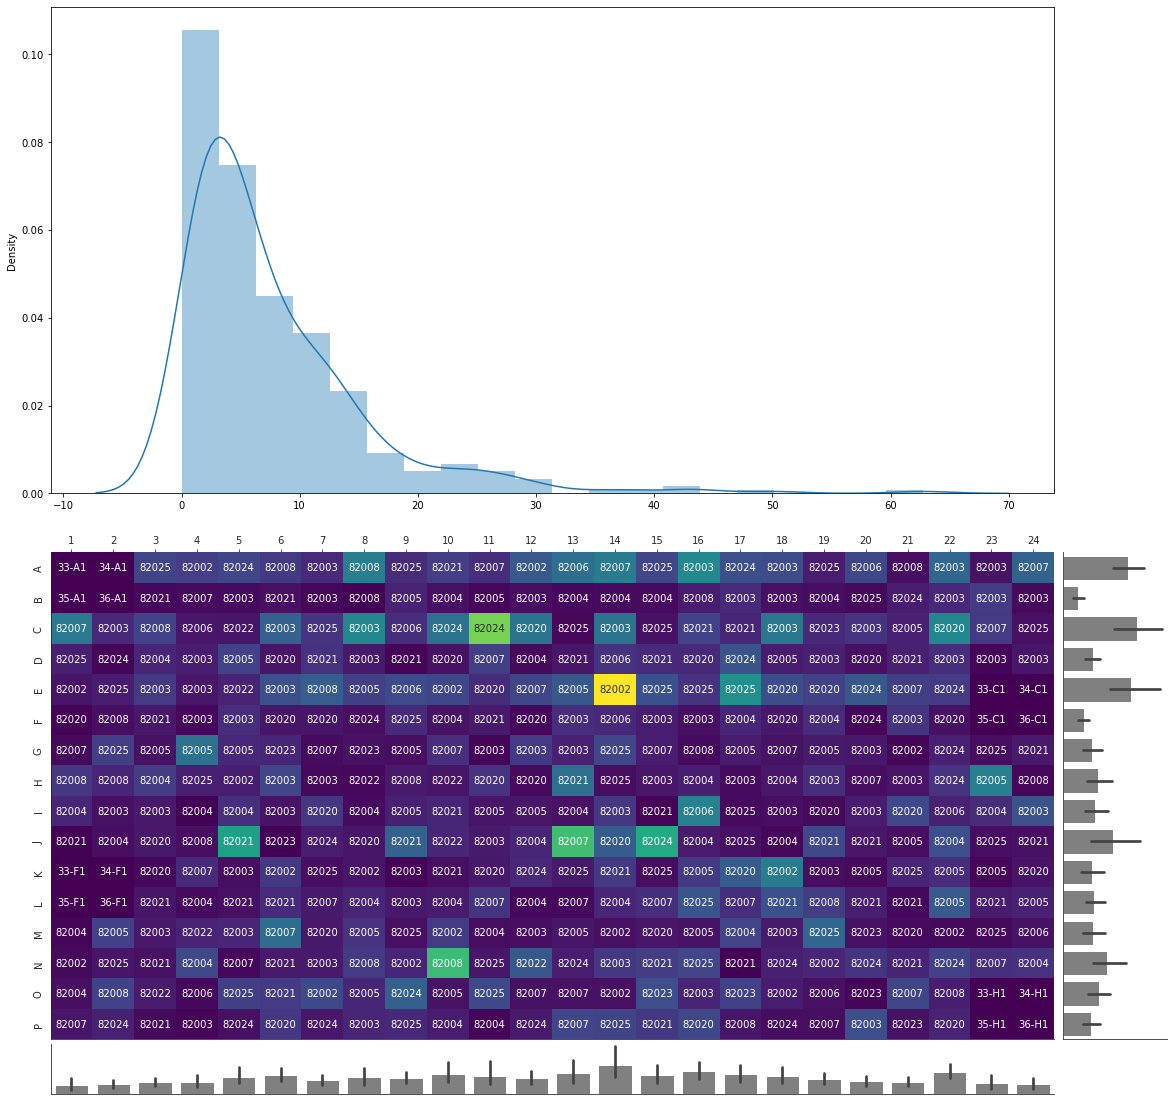

In [6]:
# get DNA concentratin information
dna_concs = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col=well_col).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col='Sample', well_col=well_col)

plot_plate_vals(dna_concs,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.5s')

In [7]:
# Make mask arrays for even and odd rows and columns

even_rows = [x for x in range(16) if x % 2 == 0]
odd_rows = [x for x in range(16) if x % 2 == 1]
even_cols = [x for x in range(24) if x % 2 == 0]
odd_cols = [x for x in range(24) if x % 2 == 1]

### gDNA concentration heatmap, Plate 1

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


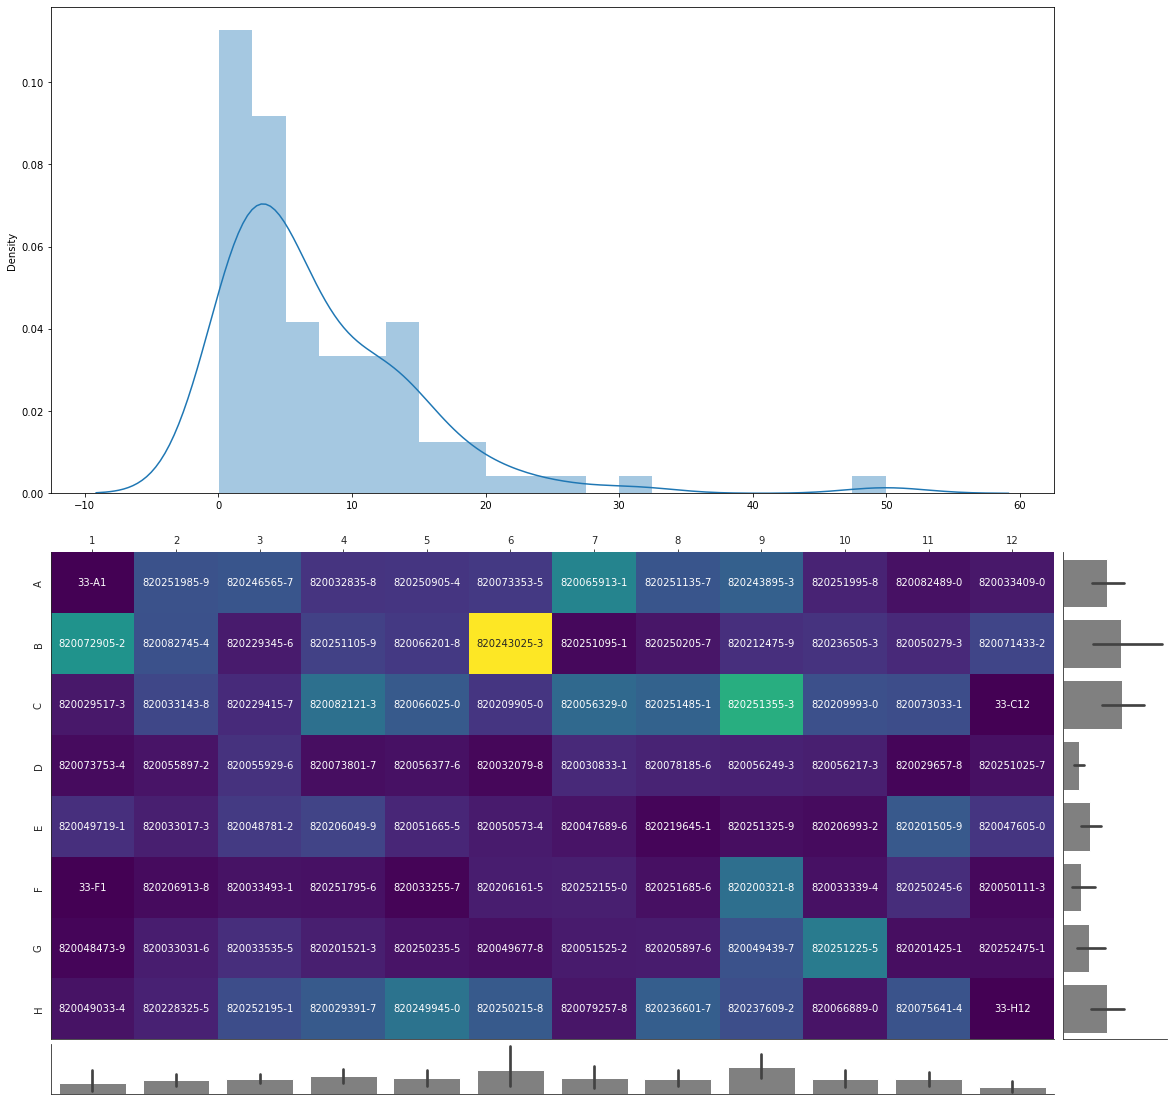

In [8]:
plot_plate_vals(dna_concs[np.ix_(even_rows,even_cols)],
                annot_str= names[np.ix_(even_rows,even_cols)],
                color_map='viridis',
                annot_fmt='')

### gDNA concentration heatmap, Plate 2

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


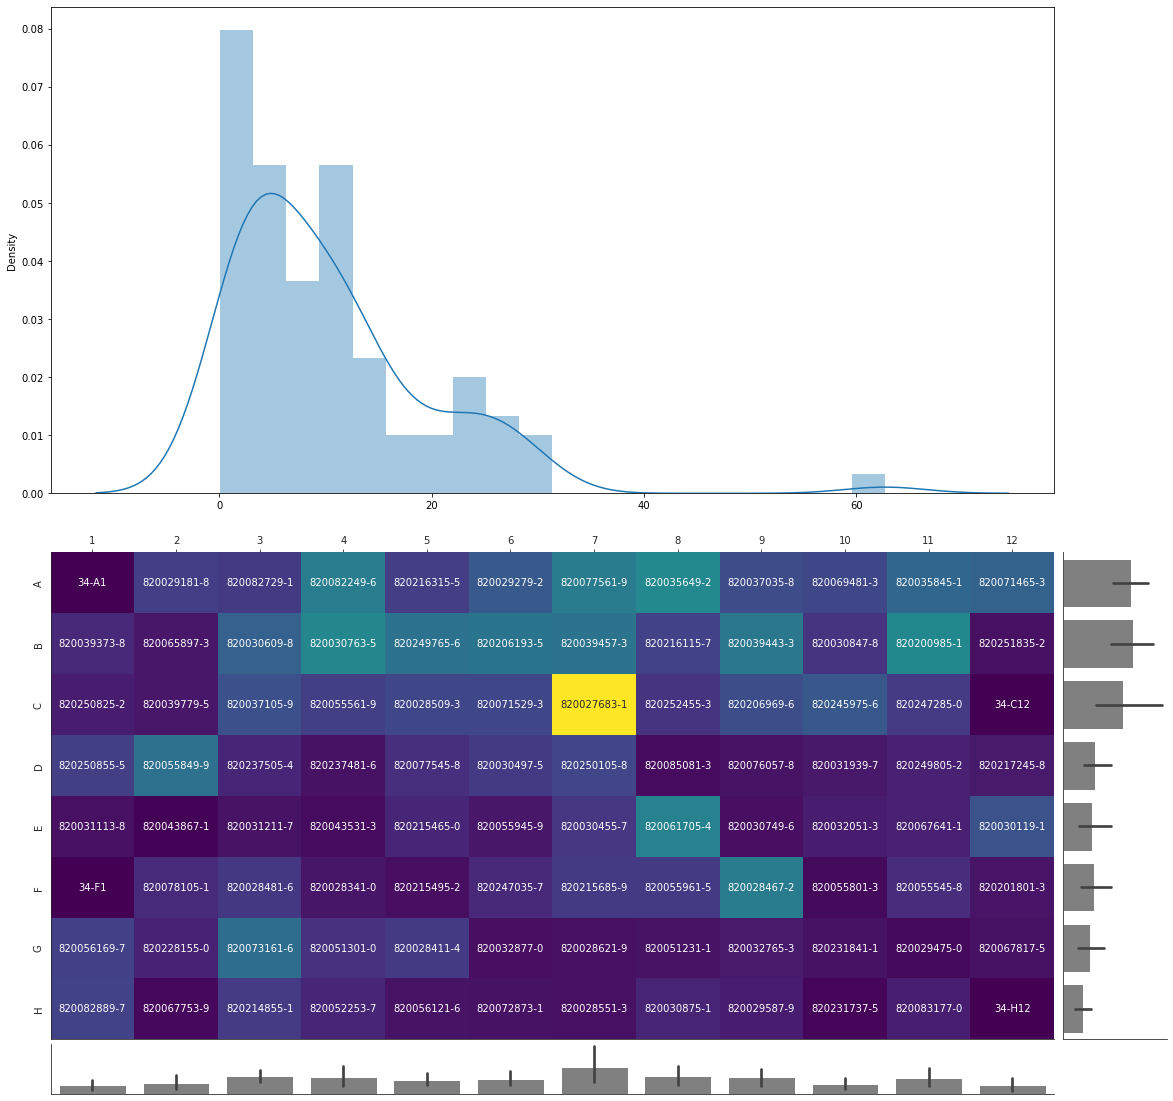

In [9]:
plot_plate_vals(dna_concs[np.ix_(even_rows,odd_cols)],
                annot_str=names[np.ix_(even_rows,odd_cols)],
                color_map='viridis',
                annot_fmt='')

### gDNA concentration heatmap, Plate 3

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


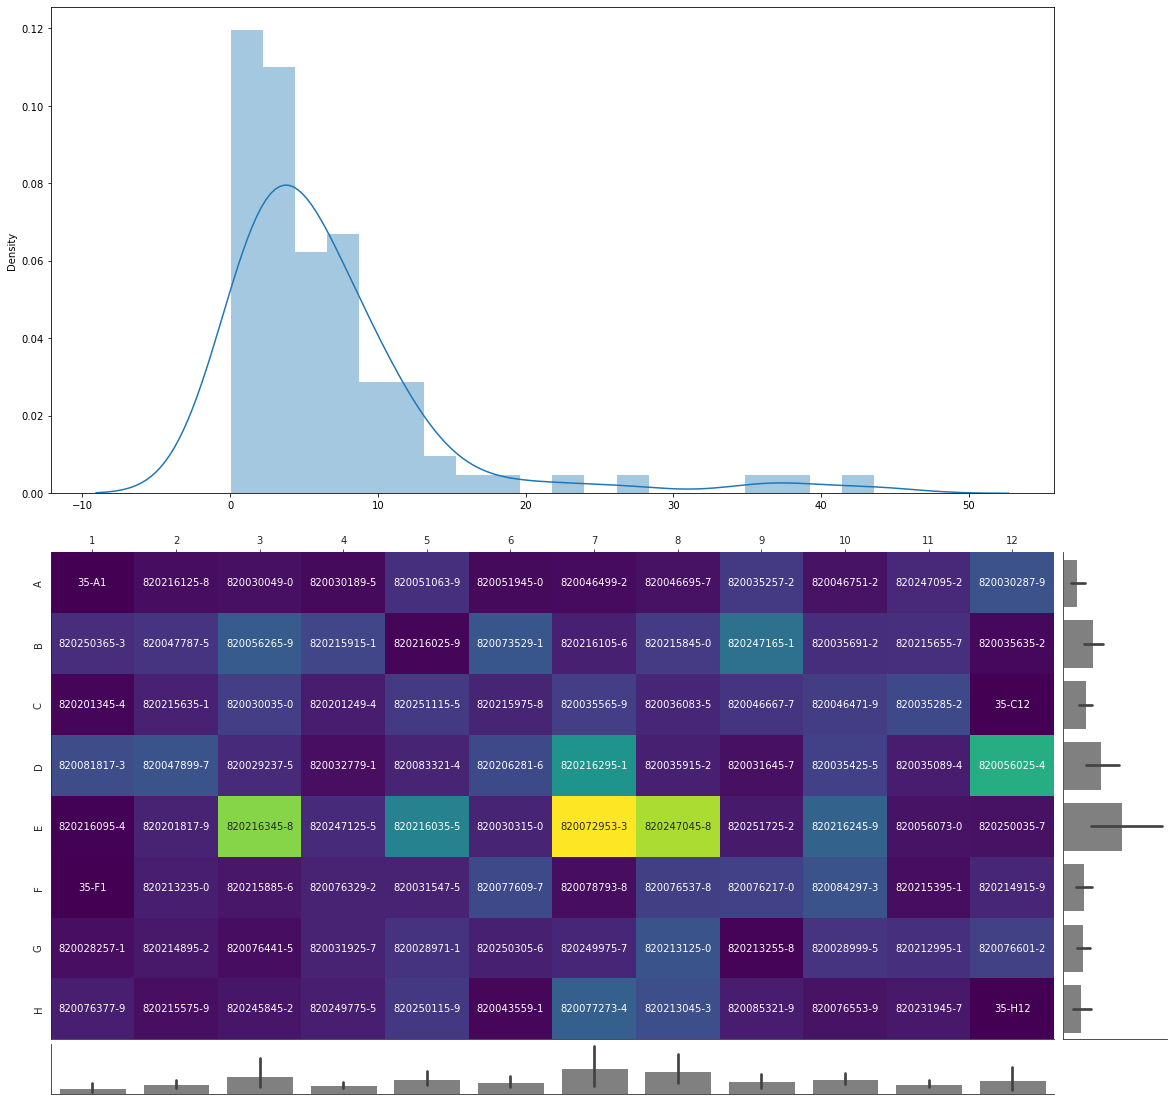

In [10]:
plot_plate_vals(dna_concs[np.ix_(odd_rows, even_cols)],
                annot_str=names[np.ix_(odd_rows, even_cols)],
                color_map='viridis',
                annot_fmt='')

### gDNA concentration heatmap, Plate 4

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


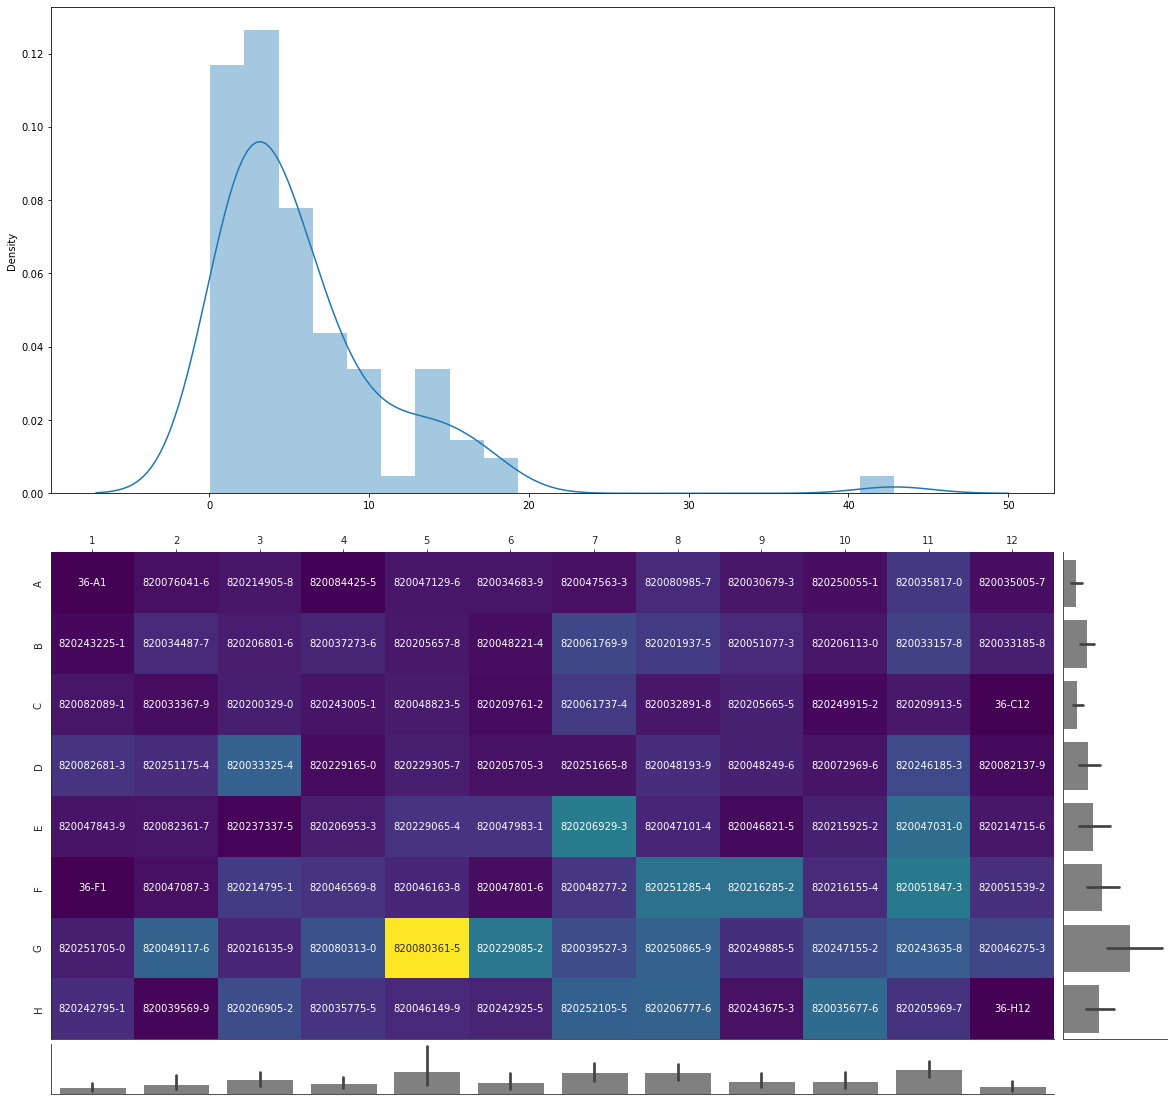

In [11]:
plot_plate_vals(dna_concs[np.ix_(odd_rows, odd_cols)],
                annot_str=names[np.ix_(odd_rows, odd_cols)],
                color_map='viridis',
                annot_fmt='')

## Step 3: calculate normalization volumes and add to plate map

This step will calculate volumes for the DNA normalization pick list.

Check the desired values for:
 - **`ng`**: the desired quantity of DNA in normed plate, in ng
 - **`total_vol`**: the total volume of normalized DNA, in nL
 - **`min_vol`**: the minimum quantity of sample to add, in nL
 - **`resolution`**: the resolution of the Echo, in nL (usually 2.5)

In [12]:
ng = 5
total_vol = 3500
min_vol = 25
resolution = 2.5

dna_vols = calculate_norm_vol(plate_df['Sample DNA Concentration'], ng=ng, min_vol=min_vol, max_vol=total_vol, resolution=resolution)
water_vols = total_vol - dna_vols

plate_df['Normalized DNA volume'] = dna_vols
plate_df['Normalized water volume'] = water_vols

plate_df.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume
0,33-A1,A,1,True,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,A1,0.044,3500.0,0.0
1,820072905-2,C,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,C1,25.654,195.0,3305.0
2,820029517-3,E,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,E1,3.336,1500.0,2000.0
3,820073753-4,G,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,G1,1.529,3270.0,230.0
4,820049719-1,I,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,I1,6.705,745.0,2755.0


## Step 3b (optional): reformat plate

You can optionally assign a different set of destination well locations per sample if you want to reformat the plate. 

In [13]:
plate_df['Library Well'] = plate_df['Well']

# # Uncomment this line to reformat from interleaved to columns
# plate_df['Library Well'] = reformat_interleaved_to_columns(plate_df['Well'])

well_col = 'Library Well'

plate_df.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,Library Well
0,33-A1,A,1,True,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,A1,0.044,3500.0,0.0,A1
1,820072905-2,C,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,C1,25.654,195.0,3305.0,C1
2,820029517-3,E,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,E1,3.336,1500.0,2000.0,E1
3,820073753-4,G,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,G1,1.529,3270.0,230.0,G1
4,820049719-1,I,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,I1,6.705,745.0,2755.0,I1


## Step 4: make pick list

Format the Echo-compatible pick list.

In [14]:
norm_picklist = format_dna_norm_picklist(np.array(plate_df['Normalized DNA volume']),
                                        np.array(plate_df['Normalized water volume']),
                                        np.array(plate_df['Well']),
                                        dest_wells = np.array(plate_df[well_col]),
                                        sample_names = np.array(plate_df['Sample']),
                                        dna_concs = np.array(plate_df['Sample DNA Concentration']))

## Step 5: write pick list to file

In [15]:
# Write the picklist as .txt
norm_picklist_fp = './test_output/Input_Norm/YYYY_MM_DD_FinRisk_33-36_inputnorm.txt'

if os.path.isfile(norm_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [16]:
with open(norm_picklist_fp, 'w') as f:
    f.write(norm_picklist)
    
!head {norm_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Concentration	Transfer Volume	Destination Plate Name	Destination Well
33-A1	Water	384PP_AQ_BP2_HT	A1	0.044	0.0	NormalizedDNA	A1
820072905-2	Water	384PP_AQ_BP2_HT	C1	25.654	3305.0	NormalizedDNA	C1
820029517-3	Water	384PP_AQ_BP2_HT	E1	3.336	2000.0	NormalizedDNA	E1
820073753-4	Water	384PP_AQ_BP2_HT	G1	1.529	230.0	NormalizedDNA	G1
820049719-1	Water	384PP_AQ_BP2_HT	I1	6.705	2755.0	NormalizedDNA	I1
33-F1	Water	384PP_AQ_BP2_HT	K1	0.055	0.0	NormalizedDNA	K1
820048473-9	Water	384PP_AQ_BP2_HT	M1	0.811	0.0	NormalizedDNA	M1
820049033-4	Water	384PP_AQ_BP2_HT	O1	2.441	1452.5	NormalizedDNA	O1
820251985-9	Water	384PP_AQ_BP2_HT	A3	12.605	3102.5	NormalizedDNA	A3


# Workflow for assigning barcodes

This portion of the notebook will assign index values and construct an Echo picklist file for adding barcodes. 

As inputs, it requires:
1. A plate map dataframe (from previous step)
2. A tab-delimited index combination file, relating index combinations, i5 and i7 index values, and i5 and i7 index locations

The workflow then:
1. reads in the index combo list
2. assigns indices per sample
3. produces an Echo-formatted pick list file

## Step 1: Read in index combo list

This is a file that contains every possible i5 and i7 barcode combo on a separate line,
along with plate and well location information. It should look something like this:

```
index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,ACCGACAAACGTTACC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate
1,AGTGGCAACTGTGTTG,iTru5_01_B,AGTGGCAA,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate
2,CACAGACTTGAGGTGT,iTru5_01_C,CACAGACT,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate
3,CGACACTTGATCCATG,iTru5_01_D,CGACACTT,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate
4,GACTTGTGGCCTATCA,iTru5_01_E,GACTTGTG,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate
5,GTGAGACTAACAACCG,iTru5_01_F,GTGAGACT,F1,iTru5_plate,iTru7_101_06,AACAACCG,A6,iTru7_plate
6,GTTCCATGACTCGTTG,iTru5_01_G,GTTCCATG,G1,iTru5_plate,iTru7_101_07,ACTCGTTG,A7,iTru7_plate
7,TAGCTGAGCCTATGGT,iTru5_01_H,TAGCTGAG,H1,iTru5_plate,iTru7_101_08,CCTATGGT,A8,iTru7_plate
8,CTTCGCAATGTACACC,iTru5_02_A,CTTCGCAA,I1,iTru5_plate,iTru7_101_09,TGTACACC,A9,iTru7_plate
```

In [17]:
index_combo_fp = './test_output/iTru/temp_iTru_combos.csv'

if not os.path.isfile(index_combo_fp):
    print("Problem! %s is not a path to a valid file" % file)

In [18]:
index_combos = pd.read_csv(index_combo_fp)
index_combos.head()

,index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,0,AACGCACACTCGTCTT,iTru5_19_A,AACGCACA,A1,iTru5_plate,iTru7_109_01,CTCGTCTT,A22,iTru7_plate
1,1,ATGCCTAGCGAACTGT,iTru5_19_B,ATGCCTAG,B1,iTru5_plate,iTru7_109_02,CGAACTGT,B22,iTru7_plate
2,2,CATACGGACATTCGGT,iTru5_19_C,CATACGGA,C1,iTru5_plate,iTru7_109_03,CATTCGGT,C22,iTru7_plate
3,3,GGTCACTATCGGTTAC,iTru5_19_D,GGTCACTA,D1,iTru5_plate,iTru7_109_04,TCGGTTAC,D22,iTru7_plate
4,4,GTATTCCGAAGTCGAG,iTru5_19_E,GTATTCCG,E1,iTru5_plate,iTru7_109_05,AAGTCGAG,E22,iTru7_plate


## Step 2: Assign index combo

This will pick a set of index combos from the index combo for the number of samples in the `plate_df` DataFrame.

Keep track of the barcode combinations used in the lab, and set `starting_combo` equal to the next unused combination.

One of way of doing that might be to keep track of the number of plates run, and set `starting_combo` equal to
384 * number of plates run + 1.

In [19]:
primerplate_combo = 4

starting_combo = (primerplate_combo - 1)*384

indices = assign_index(len(plate_df['Sample']), index_combos, start_idx=starting_combo).reset_index()

plate_df = pd.concat([plate_df, indices], axis=1)

plate_df.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well,Sample DNA Concentration,Normalized DNA volume,...,index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,33-A1,A,1,True,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,A1,0.044,3500.0,...,1152,AACGCACACGATAGAG,iTru5_19_A,AACGCACA,A1,iTru5_plate,iTru7_111_01,CGATAGAG,I23,iTru7_plate
1,820072905-2,C,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,C1,25.654,195.0,...,1153,ATGCCTAGTTCGTTGG,iTru5_19_B,ATGCCTAG,B1,iTru5_plate,iTru7_111_02,TTCGTTGG,J23,iTru7_plate
2,820029517-3,E,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,E1,3.336,1500.0,...,1154,CATACGGATGGAGAGT,iTru5_19_C,CATACGGA,C1,iTru5_plate,iTru7_111_03,TGGAGAGT,K23,iTru7_plate
3,820073753-4,G,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,G1,1.529,3270.0,...,1155,GGTCACTATCAGACGA,iTru5_19_D,GGTCACTA,D1,iTru5_plate,iTru7_111_04,TCAGACGA,L23,iTru7_plate
4,820049719-1,I,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,I1,6.705,745.0,...,1156,GTATTCCGGACGAATG,iTru5_19_E,GTATTCCG,E1,iTru5_plate,iTru7_111_05,GACGAATG,M23,iTru7_plate


## Step 3: Make index pick list

Format the Echo-compatible pick list.

In [20]:
index_picklist = format_index_picklist(plate_df['Sample'], plate_df[well_col], indices)

## Step 5: write pick list to file

In [21]:
# Write the picklist as .txt
index_picklist_fp = './test_output/Indices/YYYY_MM_DD_FinRisk_33-36_indices.txt'

if os.path.isfile(index_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [22]:
with open(index_picklist_fp, 'w') as f:
    f.write(index_picklist)

!head {index_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Transfer Volume	Index Name	Index Sequence	Index Combo	Destination Plate Name	Destination Well
33-A1	iTru5_plate	384LDV_AQ_B2_HT	A1	250	iTru5_19_A	AACGCACA	1152	IndexPCRPlate	A1
820072905-2	iTru5_plate	384LDV_AQ_B2_HT	B1	250	iTru5_19_B	ATGCCTAG	1153	IndexPCRPlate	C1
820029517-3	iTru5_plate	384LDV_AQ_B2_HT	C1	250	iTru5_19_C	CATACGGA	1154	IndexPCRPlate	E1
820073753-4	iTru5_plate	384LDV_AQ_B2_HT	D1	250	iTru5_19_D	GGTCACTA	1155	IndexPCRPlate	G1
820049719-1	iTru5_plate	384LDV_AQ_B2_HT	E1	250	iTru5_19_E	GTATTCCG	1156	IndexPCRPlate	I1
33-F1	iTru5_plate	384LDV_AQ_B2_HT	F1	250	iTru5_19_F	TGGCTCTT	1157	IndexPCRPlate	K1
820048473-9	iTru5_plate	384LDV_AQ_B2_HT	G1	250	iTru5_19_G	CTCTATCG	1158	IndexPCRPlate	M1
820049033-4	iTru5_plate	384LDV_AQ_B2_HT	H1	250	iTru5_19_H	AGGAGGTT	1159	IndexPCRPlate	O1
820251985-9	iTru5_plate	384LDV_AQ_B2_HT	I1	250	iTru5_20_A	TGATCACG	1160	IndexPCRPlate	A3


# Workflow for calculating pooling

This portion of the notebook calculates pooling based on qPCR values, and produces visual outputs to interpret and check values. 

As inputs, this workflow requires:
1. A plate map DataFrame (from previous step)
2. qPCR output (tab-delimited text format with columns 'Cp' and 'Pos')

The workflow:
1. reads in qPCR output and calculates estimated library concentration
4. calculates pooling values and generates an Echo pick list

## Step 1: read in input files

**Enter the correct path to the qPCR output file**.

In [23]:
qpcr_input_fp = './test_data/Quant/qPCR/20170914_KHP_FinRisk_33-36_qPCR.txt'

for file in [qpcr_input_fp]:
    if not os.path.isfile(file):
        print("Problem! %s is not a path to a valid file" % file)

### Read in qPCR output. 

This file should look something like this:

```
Experiment: 2017-05-19_Knight_CF+ABTX+AGP_KHP_rerun  Selected Filter: SYBR Green I / HRM Dye (465-510)
Include	Color	Pos	Name	Cp	Concentration	Standard	Status
True	255	A1	Sample 1	20.55		0	
True	255	A2	Sample 2	  9.15		0	
True	255	A3	Sample 3	  9.16		0	
True	255	A4	Sample 4	  8.89		0	
True	255	A5	Sample 5	  8.43		0	
True	255	A6	Sample 6	  8.66		0	
True	255	A7	Sample 7	  8.84		0	
True	255	A8	Sample 8	  8.85		0
```

In [24]:
qpcr_df = pd.read_csv(qpcr_input_fp, sep = '\t', skiprows=1, header=0)
qpcr_df.head()

,Include,Color,Pos,Name,Cp,Concentration,Standard,Status
0,True,255,A1,Sample 1,13.65,NaN,0,NaN
1,True,255,A2,Sample 2,11.69,NaN,0,NaN
2,True,255,A3,Sample 3,8.78,NaN,0,NaN
3,True,255,A4,Sample 4,9.17,NaN,0,NaN
4,True,255,A5,Sample 5,11.38,NaN,0,NaN


## Step 2: add to data frame

In [25]:
plate_df = pd.merge(plate_df, qpcr_df[['Pos','Cp']], left_on=well_col, right_on='Pos')

plate_df.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well,Sample DNA Concentration,Normalized DNA volume,...,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp
0,33-A1,A,1,True,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,A1,0.044,3500.0,...,iTru5_19_A,AACGCACA,A1,iTru5_plate,iTru7_111_01,CGATAGAG,I23,iTru7_plate,A1,13.65
1,820072905-2,C,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,C1,25.654,195.0,...,iTru5_19_B,ATGCCTAG,B1,iTru5_plate,iTru7_111_02,TTCGTTGG,J23,iTru7_plate,C1,9.61
2,820029517-3,E,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,E1,3.336,1500.0,...,iTru5_19_C,CATACGGA,C1,iTru5_plate,iTru7_111_03,TGGAGAGT,K23,iTru7_plate,E1,9.63
3,820073753-4,G,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,G1,1.529,3270.0,...,iTru5_19_D,GGTCACTA,D1,iTru5_plate,iTru7_111_04,TCAGACGA,L23,iTru7_plate,G1,9.64
4,820049719-1,I,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,I1,6.705,745.0,...,iTru5_19_E,GTATTCCG,E1,iTru5_plate,iTru7_111_05,GACGAATG,M23,iTru7_plate,I1,9.67


## Step 3: calculate sample concentration

This step will calculate the estimated concentration based on Cp value. It will also add this info back to the sample data frame.

In [26]:
plate_df['Library Concentration'] = compute_qpcr_concentration(plate_df['Cp'])

plate_df.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well,Sample DNA Concentration,Normalized DNA volume,...,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp,Library Concentration
0,33-A1,A,1,True,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,A1,0.044,3500.0,...,AACGCACA,A1,iTru5_plate,iTru7_111_01,CGATAGAG,I23,iTru7_plate,A1,13.65,8.044940
1,820072905-2,C,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,C1,25.654,195.0,...,ATGCCTAG,B1,iTru5_plate,iTru7_111_02,TTCGTTGG,J23,iTru7_plate,C1,9.61,143.189007
2,820029517-3,E,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,E1,3.336,1500.0,...,CATACGGA,C1,iTru5_plate,iTru7_111_03,TGGAGAGT,K23,iTru7_plate,E1,9.63,141.162598
3,820073753-4,G,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,G1,1.529,3270.0,...,GGTCACTA,D1,iTru5_plate,iTru7_111_04,TCAGACGA,L23,iTru7_plate,G1,9.64,140.160174
4,820049719-1,I,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,I1,6.705,745.0,...,GTATTCCG,E1,iTru5_plate,iTru7_111_05,GACGAATG,M23,iTru7_plate,I1,9.67,137.195408


## Step 4: calculate pooling values

This step will calculate the sample pooling, and update the sample data frame with the pool info.

There are three possible ways to pool. Each has parameters that can be set to adjust behavior:
1. **equal volume**: This will pool an even volume per sample. 
     - ***total_vol***: The total volume to pool, in uL. Each sample will be pooled at 1/N of that volume.
2. **qpcr_floor_conc**: This will pool based on qPCR estimates of nM concentrations, 
    but samples below a minimum concentration (`floor_conc`, default 40 nM) will be included 
    at a decreased volume (`floor_vol`, default 100 nL) to avoid overdiluting the pool.
    - **min_conc**: This is the minimum concentration for a sample to be considered for pooling.
    Set to 0 to pool all samples, regardless of concentration. Increasing this will have the 
    effect of increasing pool concentration, at the expense of samples dropping out. 
    - **floor_conc**: This is the lowest concentration equivalent for which a sample will be 
    accurately pooled. Samples below this concentration will be pooled to the volume that they 
    would have been if they were actually that concentration. For example, if `floor_conc=20`, 
    and a sample at 20 nM pools at 500 nL, a sample at 40 nM will pool at 250 nL but a sample at 
    10 nM will still pool at 500 nL (rather than 1000). Increasing this value will have the effect 
    of increasing pool concentration, but decreasing read counts for low-concentration samples. 
    - **total_nmol**: This is the total number of molecules to shoot for in the pool. Increasing
    this will increase the overall volume of the pool.
3. **qpcr_minvol**: This will pool based on qPCR estimates, but

    - ***floor_vol***: Volume (nL) at which samples below floor_conc will be pooled
    - ***floor_conc***: Minimum value (nM) for pooling at real estimated value (default 40)
    - ***total_nmol***: Total number of nM to shoot for in pool



As an example, we'll compute this plate each way, and then choose one to use at the end.

In [27]:
plate_df_eqvol = plate_df.copy()
plate_df_eqvol['Pooled Volume'] = compute_shotgun_pooling_values_eqvol(np.nan_to_num(plate_df_eqvol['Library Concentration']),
                                        total_vol=100)
plate_df_eqvol.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well,Sample DNA Concentration,Normalized DNA volume,...,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp,Library Concentration,Pooled Volume
0,33-A1,A,1,True,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,A1,0.044,3500.0,...,A1,iTru5_plate,iTru7_111_01,CGATAGAG,I23,iTru7_plate,A1,13.65,8.044940,260.416667
1,820072905-2,C,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,C1,25.654,195.0,...,B1,iTru5_plate,iTru7_111_02,TTCGTTGG,J23,iTru7_plate,C1,9.61,143.189007,260.416667
2,820029517-3,E,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,E1,3.336,1500.0,...,C1,iTru5_plate,iTru7_111_03,TGGAGAGT,K23,iTru7_plate,E1,9.63,141.162598,260.416667
3,820073753-4,G,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,G1,1.529,3270.0,...,D1,iTru5_plate,iTru7_111_04,TCAGACGA,L23,iTru7_plate,G1,9.64,140.160174,260.416667
4,820049719-1,I,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,I1,6.705,745.0,...,E1,iTru5_plate,iTru7_111_05,GACGAATG,M23,iTru7_plate,I1,9.67,137.195408,260.416667


In [28]:
plate_df_minvol = plate_df.copy()
plate_df_minvol['Pooled Volume'] = compute_shotgun_pooling_values_qpcr_minvol(np.nan_to_num(plate_df_minvol['Library Concentration']),
                                        floor_vol=80, floor_conc=40,
                                        total_nmol=.008)
plate_df_minvol.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well,Sample DNA Concentration,Normalized DNA volume,...,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp,Library Concentration,Pooled Volume
0,33-A1,A,1,True,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,A1,0.044,3500.0,...,A1,iTru5_plate,iTru7_111_01,CGATAGAG,I23,iTru7_plate,A1,13.65,8.044940,80.000000
1,820072905-2,C,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,C1,25.654,195.0,...,B1,iTru5_plate,iTru7_111_02,TTCGTTGG,J23,iTru7_plate,C1,9.61,143.189007,145.495340
2,820029517-3,E,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,E1,3.336,1500.0,...,C1,iTru5_plate,iTru7_111_03,TGGAGAGT,K23,iTru7_plate,E1,9.63,141.162598,147.583946
3,820073753-4,G,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,G1,1.529,3270.0,...,D1,iTru5_plate,iTru7_111_04,TCAGACGA,L23,iTru7_plate,G1,9.64,140.160174,148.639466
4,820049719-1,I,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,I1,6.705,745.0,...,E1,iTru5_plate,iTru7_111_05,GACGAATG,M23,iTru7_plate,I1,9.67,137.195408,151.851535


In [29]:
plate_df_floor = plate_df.copy()
plate_df_floor['Pooled Volume'] = compute_shotgun_pooling_values_qpcr(np.nan_to_num(plate_df_floor['Library Concentration']),
                                        min_conc=0, floor_conc=40,
                                        total_nmol=.008)
plate_df_floor.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well,Sample DNA Concentration,Normalized DNA volume,...,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp,Library Concentration,Pooled Volume
0,33-A1,A,1,True,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,A1,0.044,3500.0,...,A1,iTru5_plate,iTru7_111_01,CGATAGAG,I23,iTru7_plate,A1,13.65,8.044940,520.833333
1,820072905-2,C,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,C1,25.654,195.0,...,B1,iTru5_plate,iTru7_111_02,TTCGTTGG,J23,iTru7_plate,C1,9.61,143.189007,145.495340
2,820029517-3,E,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,E1,3.336,1500.0,...,C1,iTru5_plate,iTru7_111_03,TGGAGAGT,K23,iTru7_plate,E1,9.63,141.162598,147.583946
3,820073753-4,G,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,G1,1.529,3270.0,...,D1,iTru5_plate,iTru7_111_04,TCAGACGA,L23,iTru7_plate,G1,9.64,140.160174,148.639466
4,820049719-1,I,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,I1,6.705,745.0,...,E1,iTru5_plate,iTru7_111_05,GACGAATG,M23,iTru7_plate,I1,9.67,137.195408,151.851535


### Visualize pooling for equal volume

The estimated pool volume and concentration are (concentration, nM; volume, nL):

In [30]:
estimate_pool_conc_vol(plate_df_eqvol['Pooled Volume'], plate_df_eqvol['Library Concentration'])

(317.94623506994816, 99999.99999999999)

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


LinAlgError: singular matrix

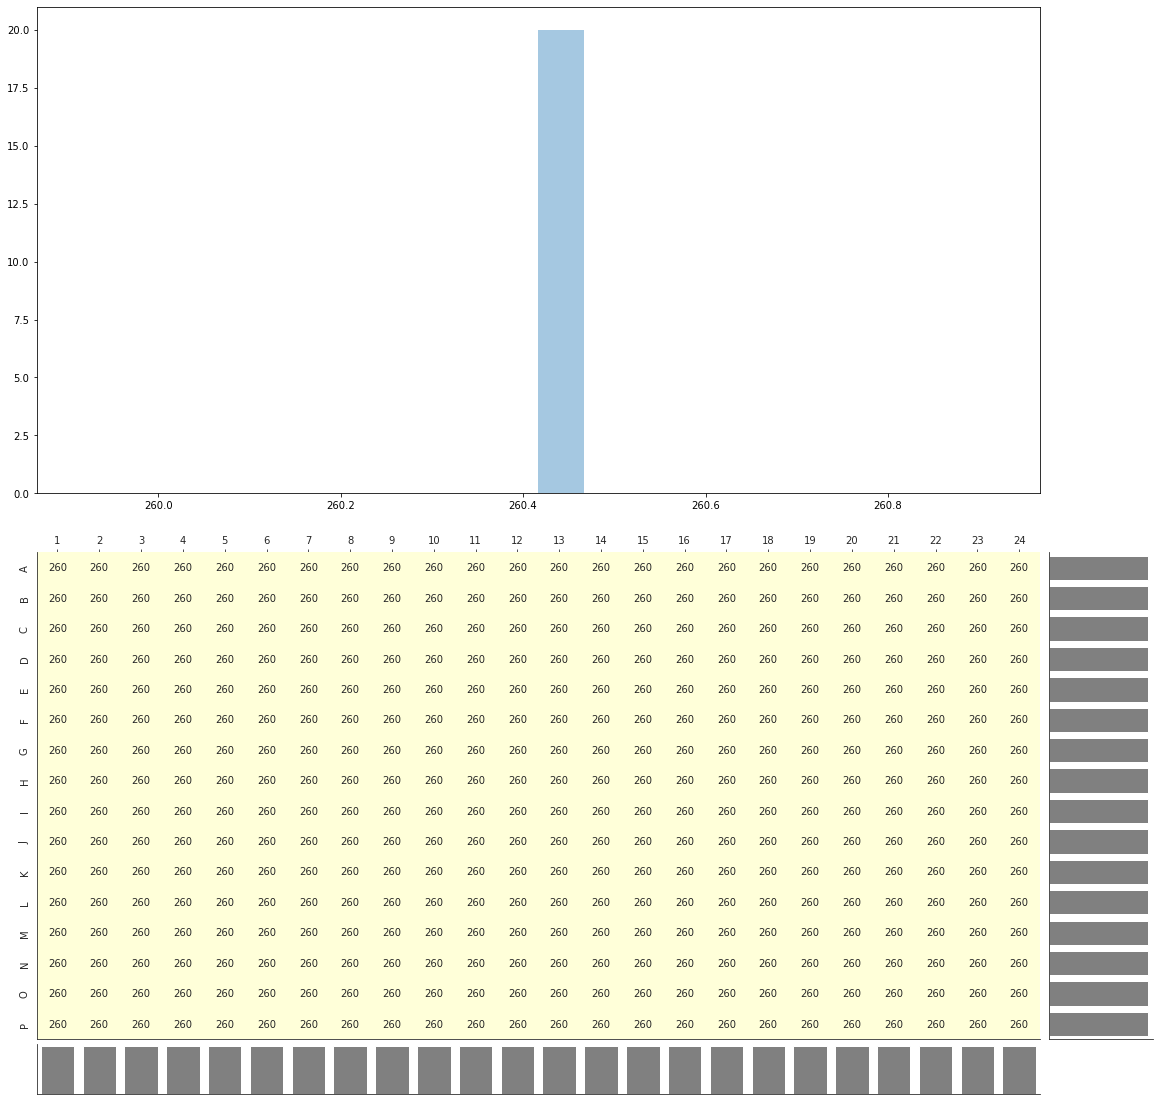

In [31]:
vols = make_2D_array(plate_df_eqvol, data_col='Pooled Volume', well_col=well_col).astype(float)

plot_plate_vals(vols)

### Visualize pooling for  minvol pooling

This will likely have a lower estimated concentration than equal volume, with blanks and very low samples pooled at `min_vol`.

In [32]:
estimate_pool_conc_vol(plate_df_minvol['Pooled Volume'], plate_df_minvol['Library Concentration'])

(253.20180016945932, 30514.411607631788)

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


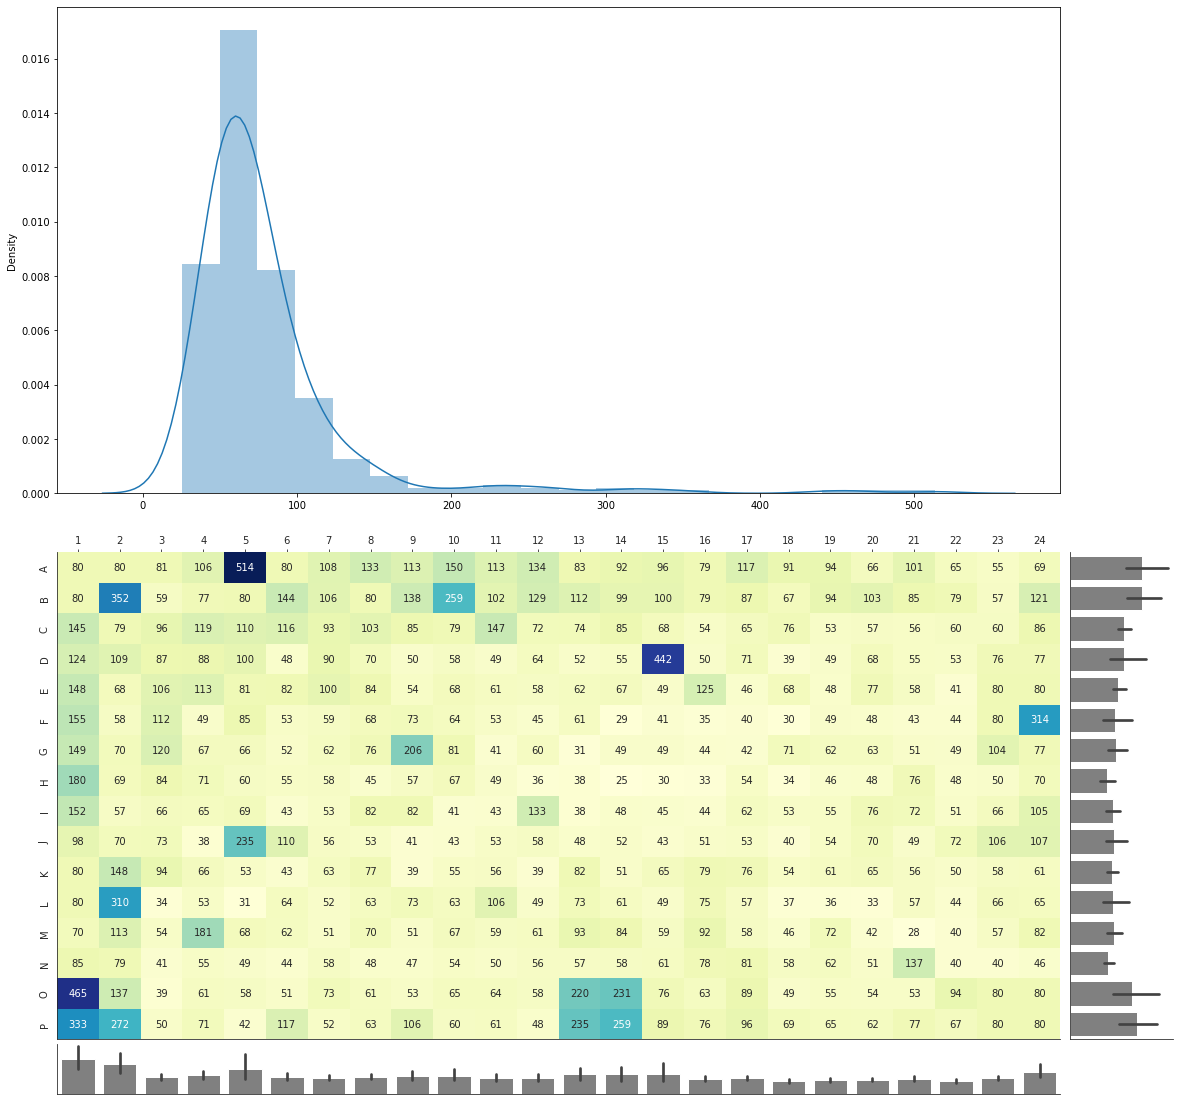

In [33]:
vols = make_2D_array(plate_df_minvol, data_col='Pooled Volume', well_col=well_col).astype(float)

plot_plate_vals(vols)

### Visualize pooling for floor conc pooling

This will likely have a lower estimated concentration than minvol, with blanks and very low samples pooled up to some high volume. 

In [34]:
estimate_pool_conc_vol(plate_df_floor['Pooled Volume'], plate_df_floor['Library Concentration'])

(213.30515292886025, 36686.07827429846)

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


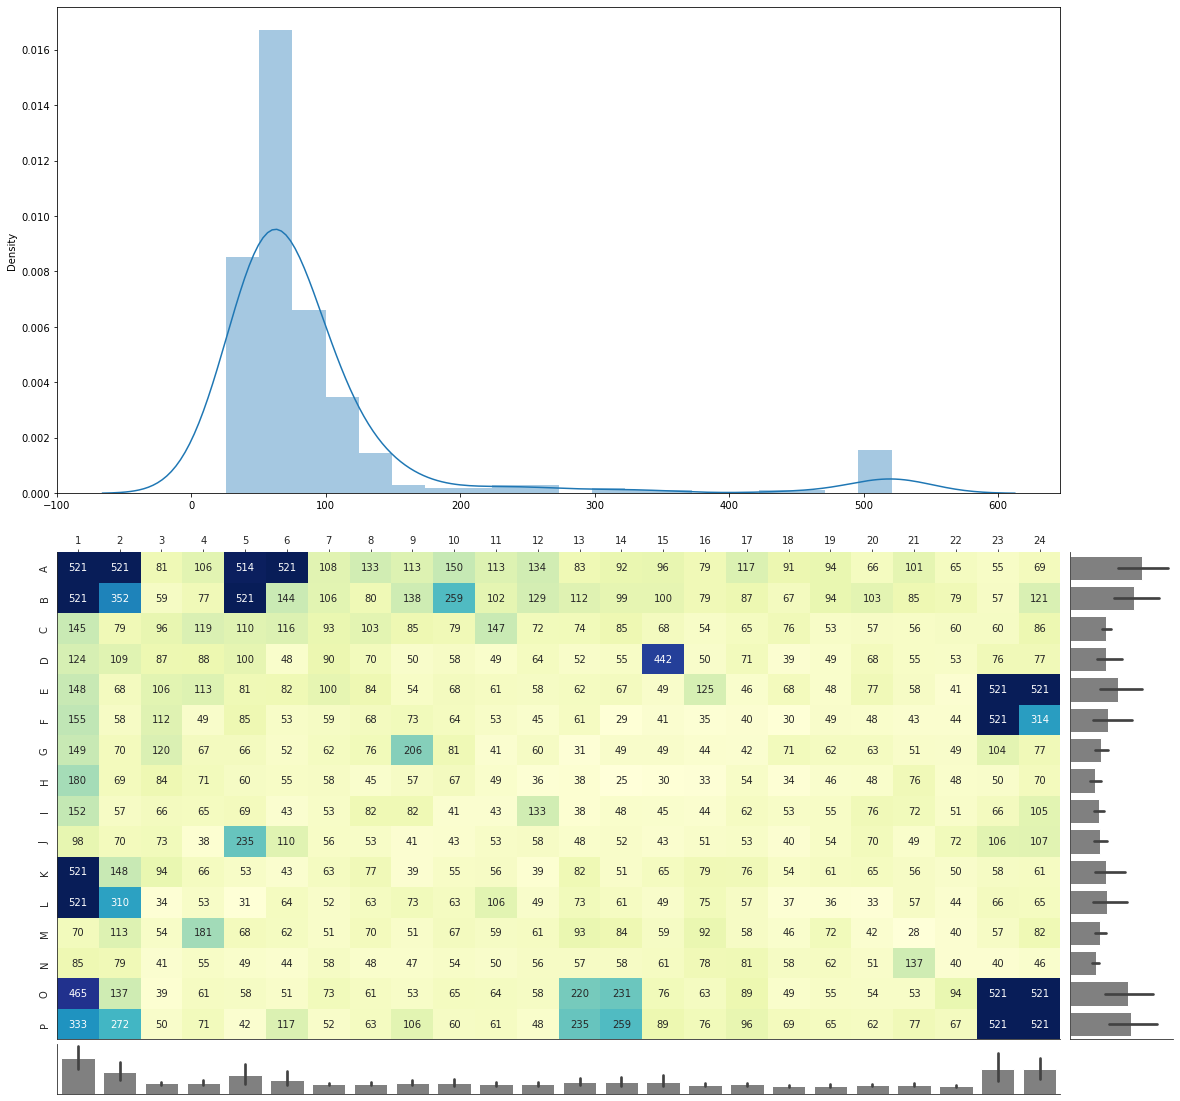

In [35]:
vols = make_2D_array(plate_df_floor, data_col='Pooled Volume', well_col=well_col).astype(float)

plot_plate_vals(vols)

### Pick one of the pooling strategies to use going forward

By default, we'll use the **minvol** approach.

In [36]:
plate_df = plate_df_minvol

## Step 5: visualization

This step will present visuals of the results, including:
1. Scatter plot of DNA concentrations by Library concentration
2. Plate-wise heatmap and histogram showing library concentrations
3. per-96-well plate heatmaps and histograms showing library concentrations and sample names
4. Plate-wise heatmap showing pooling values

### Library concentration by sample DNA concentration:

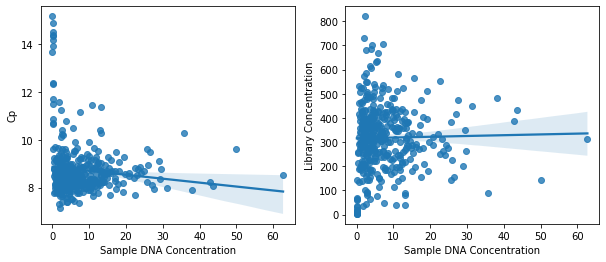

In [37]:
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.regplot(x="Sample DNA Concentration", y="Cp", data=plate_df, ax = ax1);
sns.regplot(x="Sample DNA Concentration", y="Library Concentration", data=plate_df, ax = ax2);

### Library concentration heatmap, whole plate

In [38]:
# get concentration and pooling values for plotting
concs = make_2D_array(plate_df, data_col="Library Concentration", well_col=well_col).astype(float)
vols = make_2D_array(plate_df, data_col='Pooled Volume', well_col=well_col).astype(float)
dna = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col=well_col).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col='Sample', well_col=well_col)
i5 = make_2D_array(plate_df, data_col='i5 name', well_col=well_col)
i7 = make_2D_array(plate_df, data_col='i7 name', well_col=well_col)

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


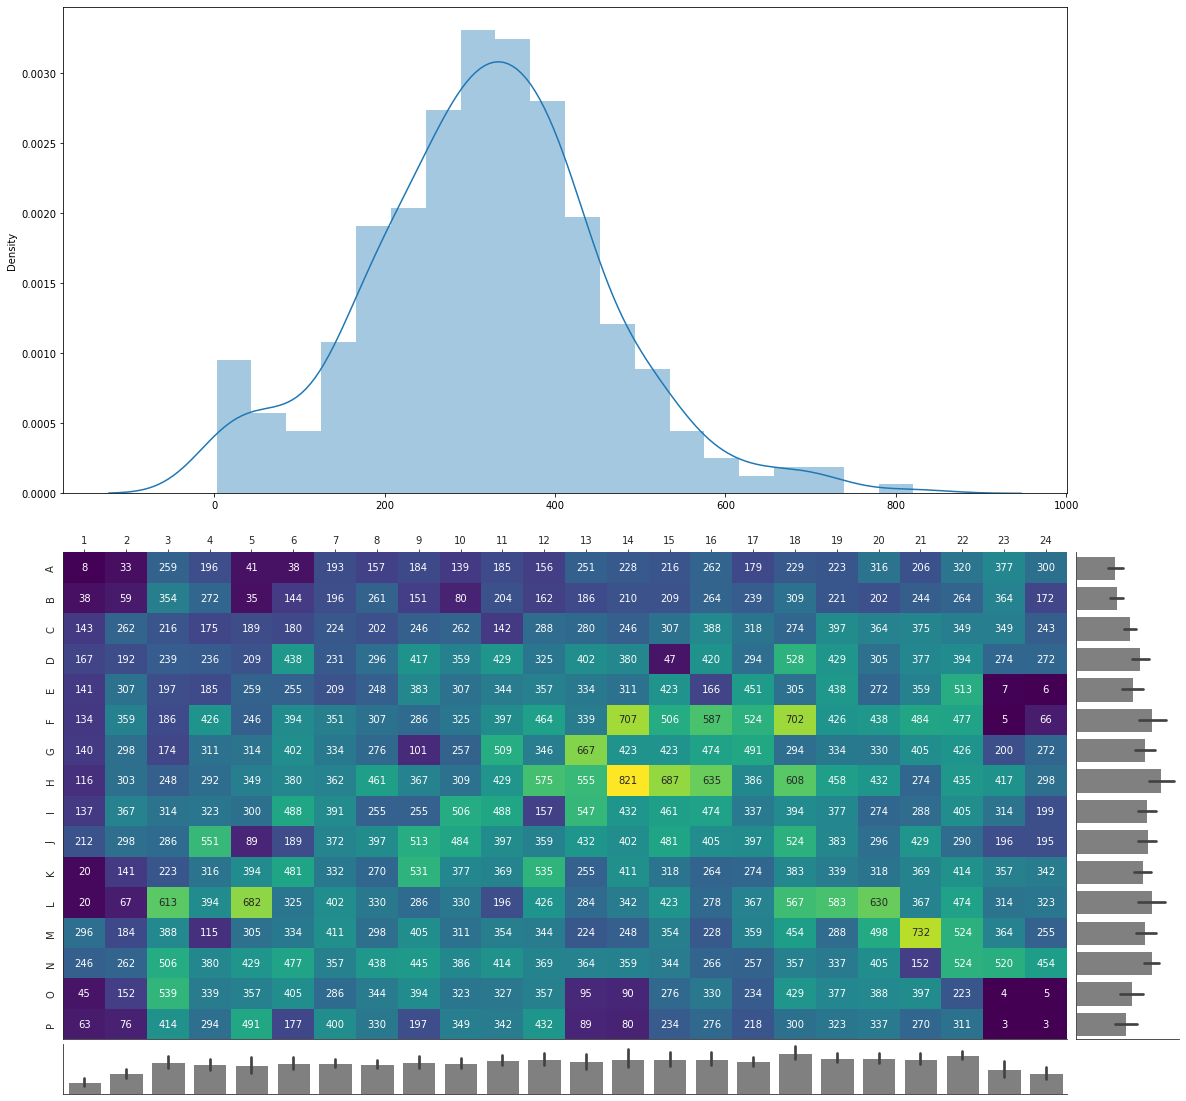

In [39]:
plot_plate_vals(concs, color_map='viridis')

### Plate maps for individual constituent plates

In [40]:
# Make mask arrays for even and odd rows and columns

even_rows = [x for x in range(16) if x % 2 == 0]
odd_rows = [x for x in range(16) if x % 2 == 1]
even_cols = [x for x in range(24) if x % 2 == 0]
odd_cols = [x for x in range(24) if x % 2 == 1]

### Library concentration heatmap, Plate 1

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


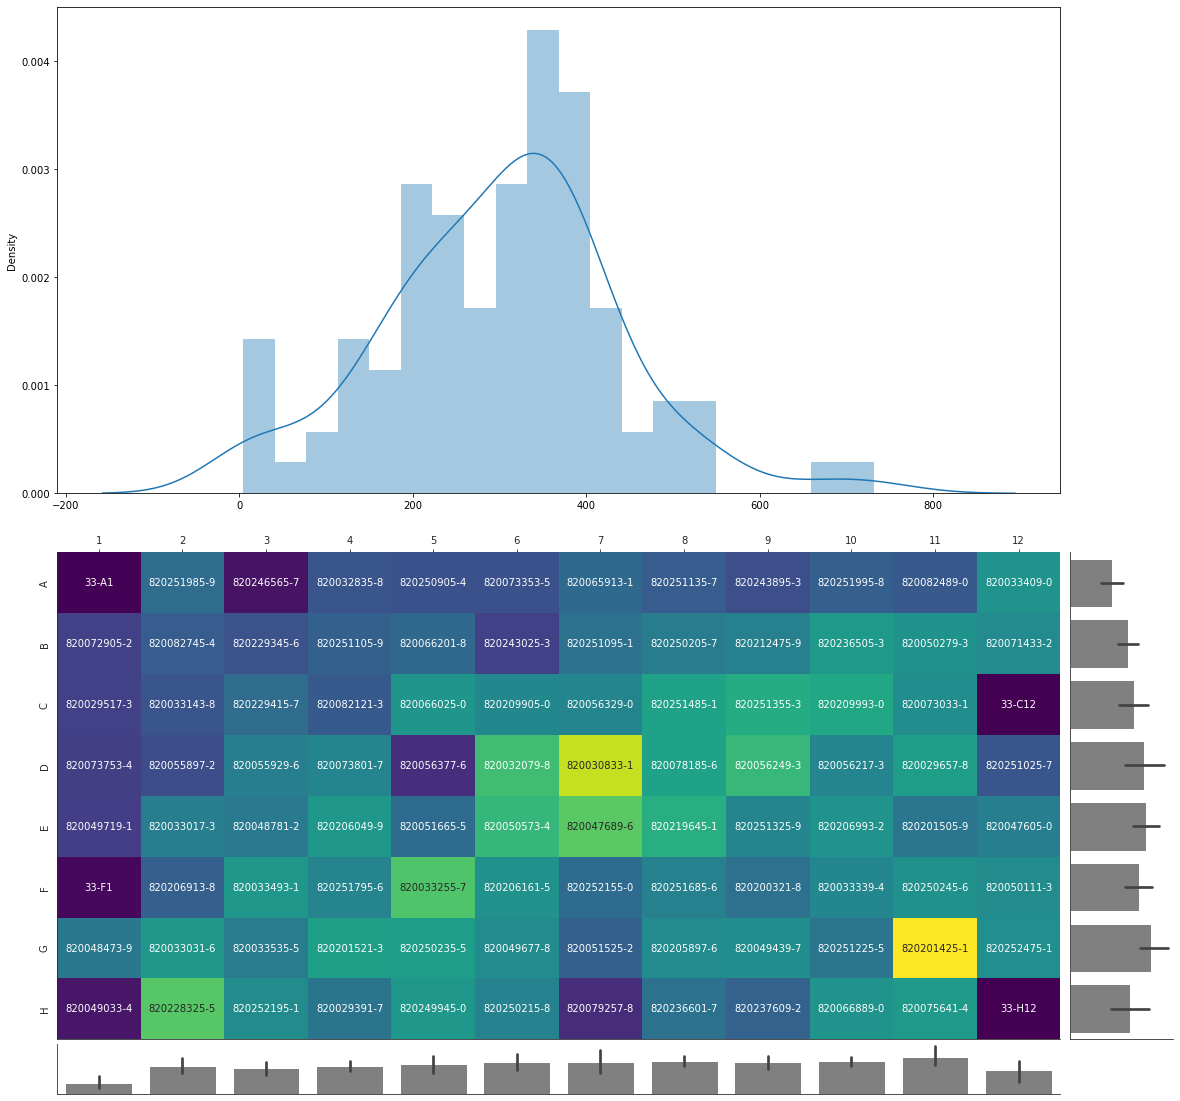

In [41]:
plot_plate_vals(concs[np.ix_(even_rows,even_cols)],
                annot_str= names[np.ix_(even_rows,even_cols)],
                color_map='viridis',
                annot_fmt='')

### Library concentration heatmap, Plate 2

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


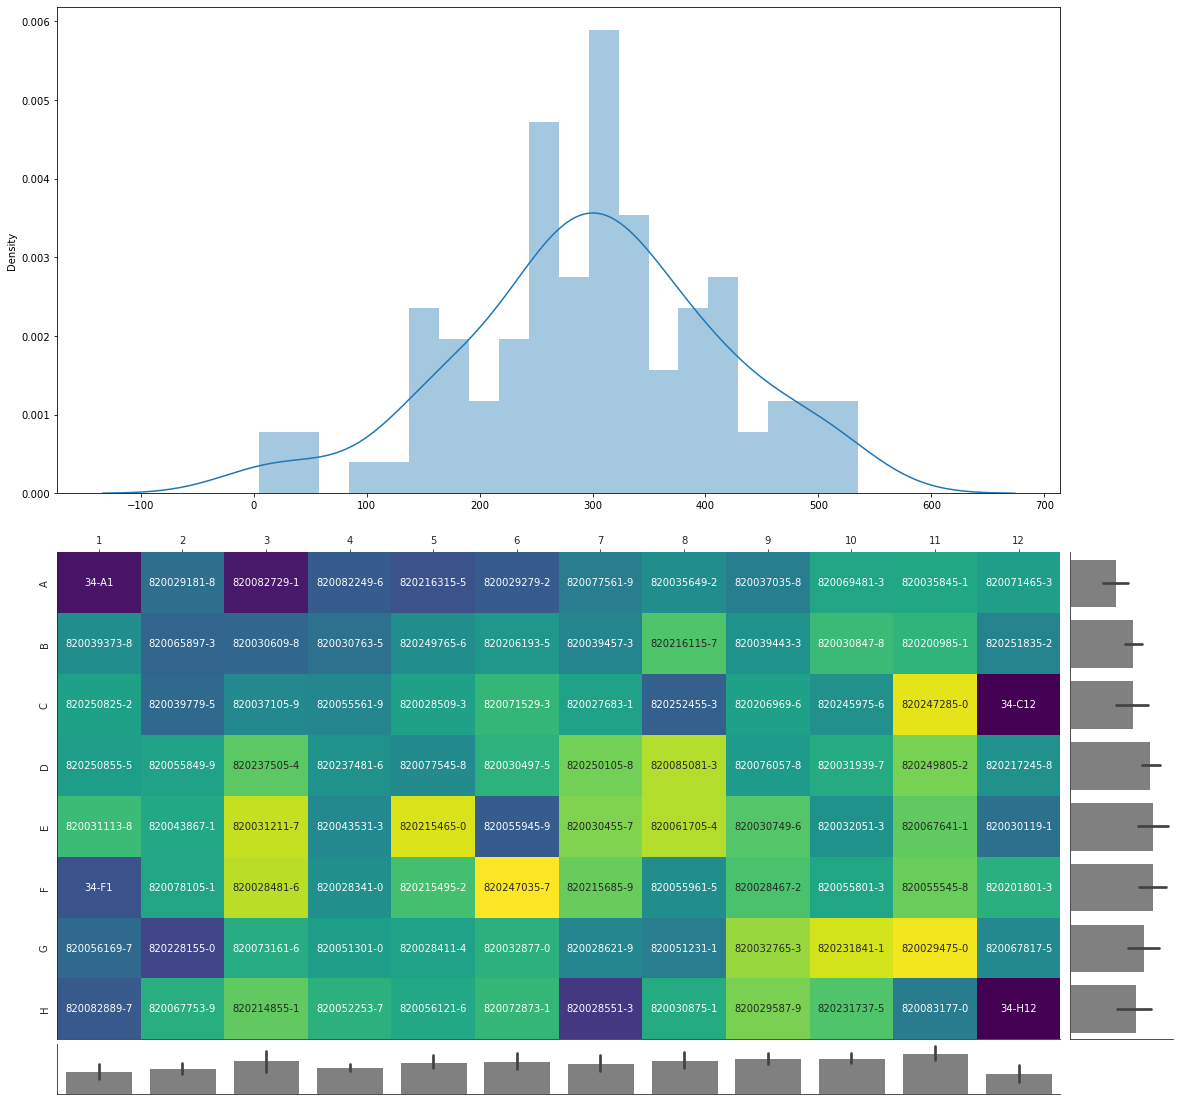

In [42]:
plot_plate_vals(concs[np.ix_(even_rows,odd_cols)],
                annot_str=names[np.ix_(even_rows,odd_cols)],
                color_map='viridis',
                annot_fmt='')

### Library concentration heatmap, Plate 3

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


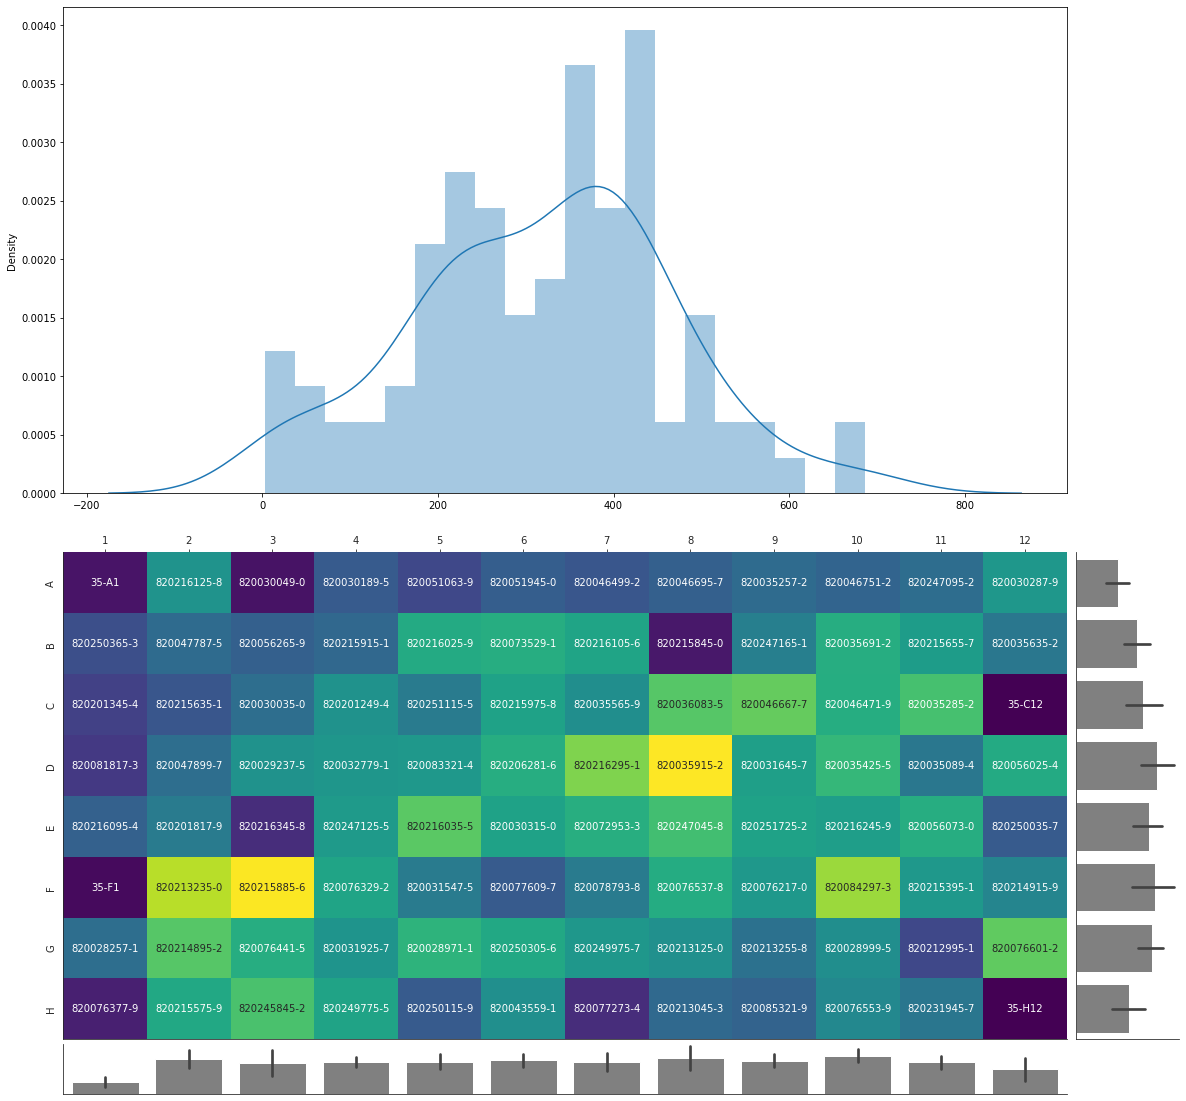

In [43]:
plot_plate_vals(concs[np.ix_(odd_rows, even_cols)],
                annot_str=names[np.ix_(odd_rows, even_cols)],
                color_map='viridis',
                annot_fmt='')

### Library concentration heatmap, Plate 4

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


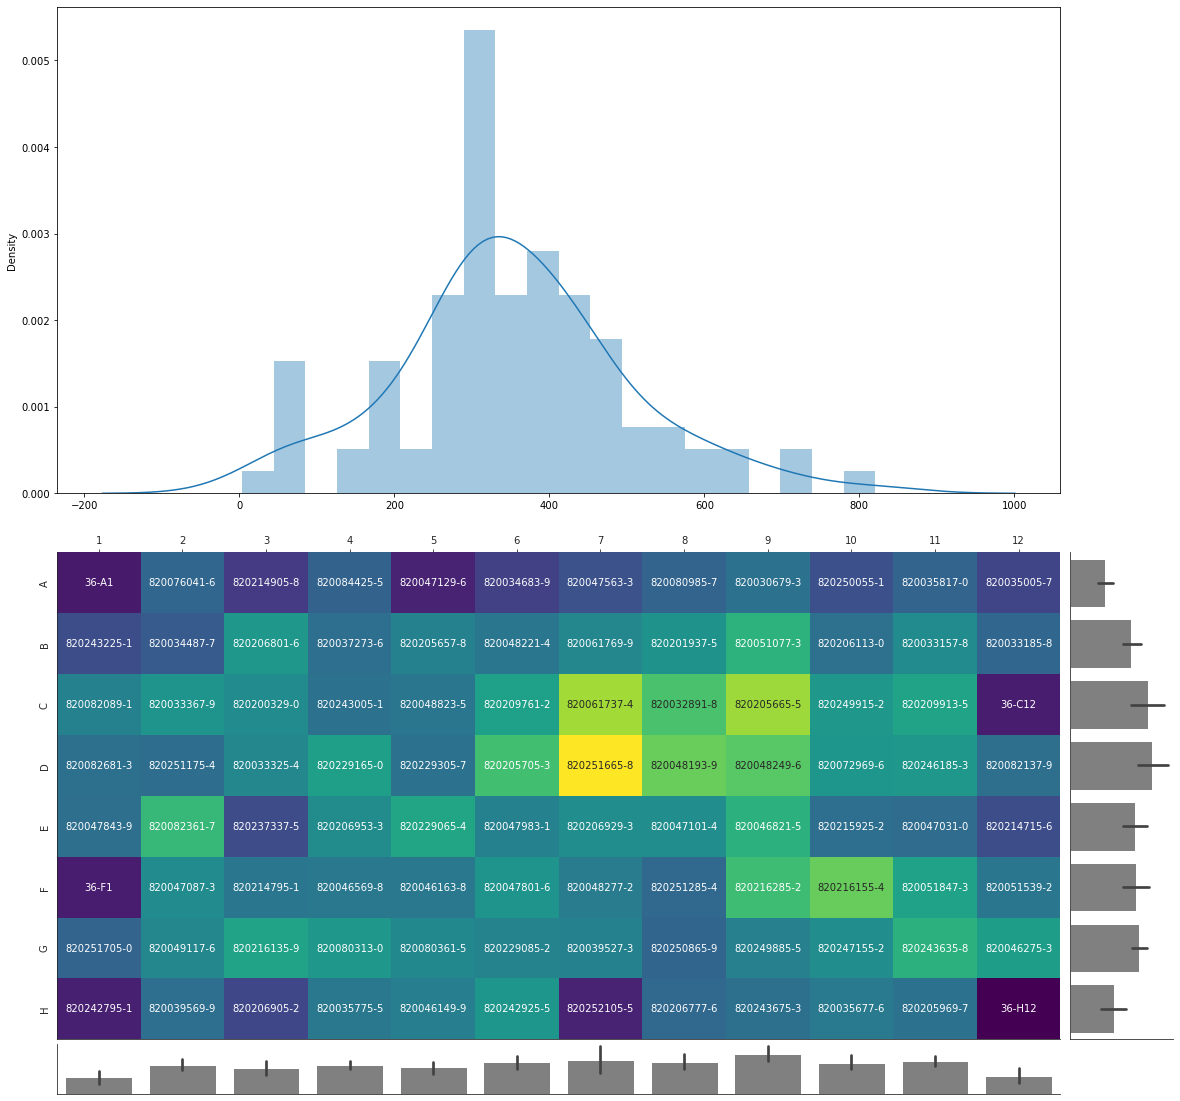

In [44]:
plot_plate_vals(concs[np.ix_(odd_rows, odd_cols)],
                annot_str=names[np.ix_(odd_rows, odd_cols)],
                color_map='viridis',
                annot_fmt='')

### Plot pooling volumes

/Users/cguccion/miniconda3/envs/pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


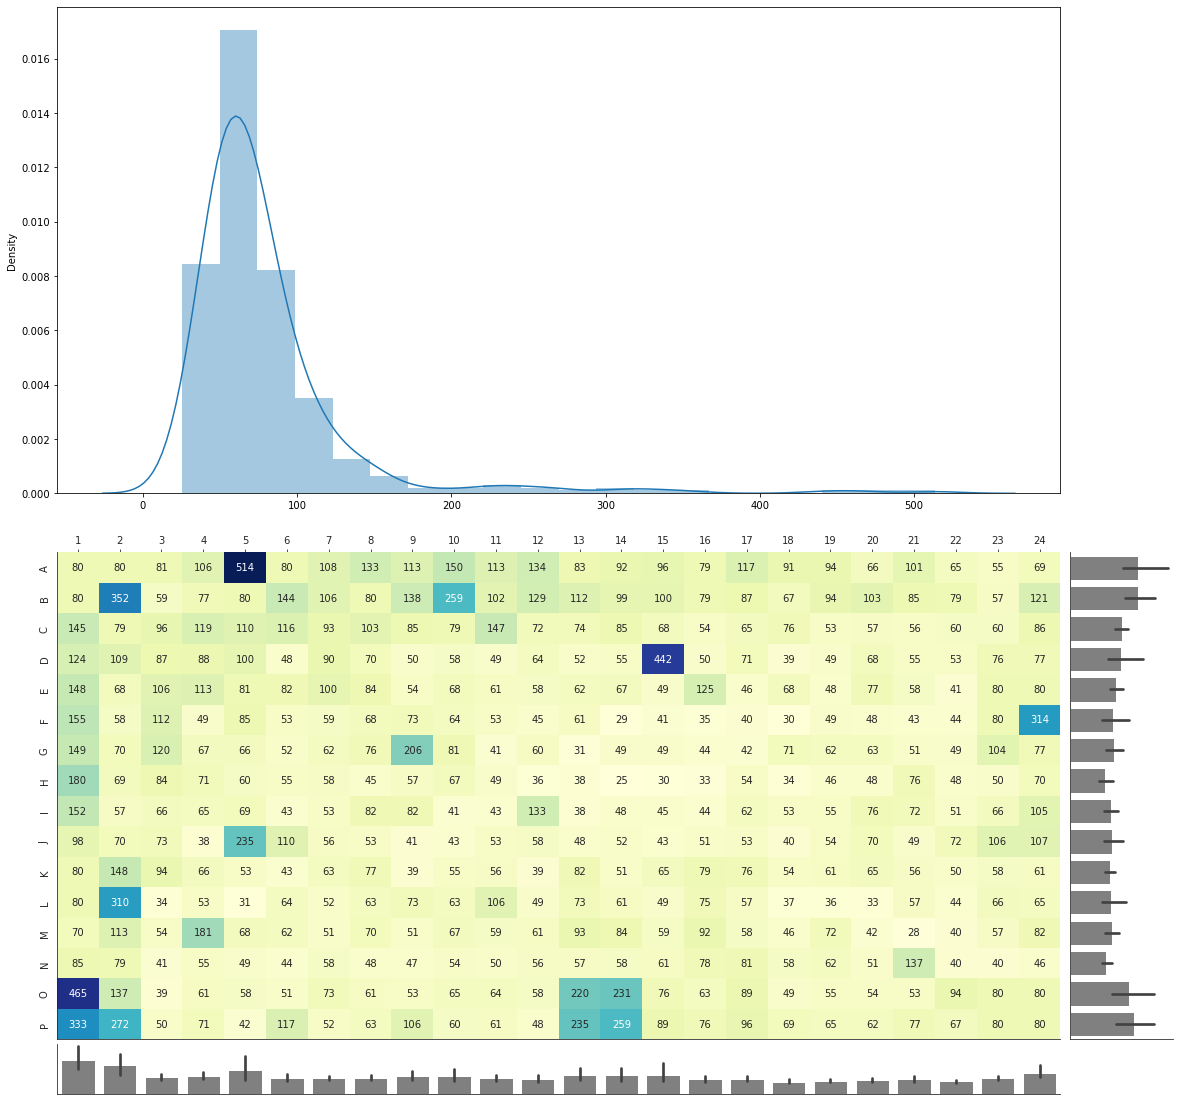

In [45]:
plot_plate_vals(vols)

## Step 6: write pooling pick list

In [46]:
# Write the picklist as .csv
picklist_fp = './test_output/Pooling/YYYY_MM_DD_FinRisk_qPCR_normpool.csv'

if os.path.isfile(picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [47]:
picklist = format_pooling_echo_pick_list(vols, max_vol_per_well=30000)
with open(picklist_fp,'w') as f:
    f.write(picklist)

!head {picklist_fp}

Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
1,384LDV_AQ_B2_HT,A1,,80.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A2,,80.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A3,,80.53,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A4,,106.33,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A5,,513.65,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A6,,80.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A7,,107.86,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A8,,132.62,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A9,,113.38,NormalizedDNA,A1


# Write DataFrame to file

We want to keep all that useful information together in one place so it can be easily parsed later. 

In [48]:
# Write the sample info DataFrame as .txt
plate_df_fp = './test_output/MRSA/2017-08-04_MRSA_plate_dataframe.txt'

if os.path.isfile(plate_df_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [49]:
plate_df.to_csv(plate_df_fp, sep='\t')

# Make HiSeq sample sheet

This workflow takes the pooled sample information and writes an Illumina sample sheet that can be given directly to the sequencing center. 

As inputs, this notebook requires:
1. A plate map DataFrame (from previous step)

The workflow:
1. formats sample names as bcl2fastq-compatible
2. formats sample data
3. sets values for sample sheet fields and formats sample sheet.
4. writes the sample sheet to a file

## Step 1: Format sample names to be bcl2fastq-compatible

bcl2fastq requires *only* alphanumeric, hyphens, and underscore characters. We'll replace all non-those characters
with underscores and add the bcl2fastq-compatible names to the DataFrame.

In [50]:
plate_df['sample sheet Sample_ID'] = plate_df['Sample'].map(bcl_scrub_name)

plate_df.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well,Sample DNA Concentration,Normalized DNA volume,...,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp,Library Concentration,Pooled Volume,sample sheet Sample_ID
0,33-A1,A,1,True,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,A1,0.044,3500.0,...,iTru5_plate,iTru7_111_01,CGATAGAG,I23,iTru7_plate,A1,13.65,8.044940,80.000000,33-A1
1,820072905-2,C,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,C1,25.654,195.0,...,iTru5_plate,iTru7_111_02,TTCGTTGG,J23,iTru7_plate,C1,9.61,143.189007,145.495340,820072905-2
2,820029517-3,E,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,E1,3.336,1500.0,...,iTru5_plate,iTru7_111_03,TGGAGAGT,K23,iTru7_plate,E1,9.63,141.162598,147.583946,820029517-3
3,820073753-4,G,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,G1,1.529,3270.0,...,iTru5_plate,iTru7_111_04,TCAGACGA,L23,iTru7_plate,G1,9.64,140.160174,148.639466,820073753-4
4,820049719-1,I,1,False,FinRisk_P33,FinRisk_10855,FinRisk Plate 33-36,I1,6.705,745.0,...,iTru5_plate,iTru7_111_05,GACGAATG,M23,iTru7_plate,I1,9.67,137.195408,151.851535,820049719-1


# Step 2: format sample sheet data

This step formats the data columns appropriately for the sample sheet, using the values we've calculated previously.

The newly-created bcl2fastq-compatible names will be in the **`Sample ID`** and **`Sample Name`** columns. The
original sample names will be in the **`Description`** column.

Modify **`lanes`** to indicate which lanes this pool will be sequenced on.

**Project Name and Project Plate values will be placed in the **`Sample_Project`** and **`Sample_Name`**
columns, respectively.

**`sequencer`** is important for making sure the i5 index is in the correct orientation for demultiplexing. `HiSeq4000`, `HiSeq3000`, `NextSeq`, and `MiniSeq` all require reverse-complemented i5 index sequences. If you enter one of these exact strings in for `sequencer`, it will revcomp the i5 sequence for you.

`HiSeq2500`, `MiSeq`, and `NovaSeq` will not revcomp the i5 sequence. 

In [51]:
plate_df['Sample_Project'] = 'Example_Project_1'
plate_df['Sample_Plate'] = 'Example Plate 1'
sequencer = 'HiSeq4000'
lanes = [1, 2, 3, 4]

# Knight Lab Kapa HP is also valid value for library_construction_protocol
metadata = {
    'Bioinformatics': [
        {
         'Sample_Project': 'Example_Project_1',
         'QiitaID': '1',
         'BarcodesAreRC': 'False',
         'ForwardAdapter': 'GATCGGAAGAGCACACGTCTGAACTCCAGTCAC',
         'ReverseAdapter': 'GATCGGAAGAGCGTCGTGTAGGGAAAGGAGTGT',
         'HumanFiltering': 'True',
         'library_construction_protocol': 'Knight Lab Nextera',
         'experiment_design_description': ' ',
        },
    ],
    'Contact': [
        {
         'Sample_Project': 'Example_Project_1',
         # non-admin contacts who want to know when the sequences
         # are available in Qiita
         'Email': 'jonsan@gmail.com'
        },
    ],
    'Assay': 'Metagenomics',
}

sheet = make_sample_sheet(metadata, plate_df, sequencer, lanes)

HiSeq4000: i5 barcodes are output as reverse compliments


Validate the contents of the sample sheet.

In [ ]:
sheet = validate_sample_sheet(sheet)

## Step 3: Write the sample sheet to file

In [52]:
# write sample sheet as .csv
sample_sheet_fp = './test_output/SampleSheets/YYYY_MM_DD_FinRisk_33-36_samplesheet.csv'

if os.path.isfile(sample_sheet_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [53]:
with open(sample_sheet_fp,'w') as f:
    sheet.write(f)
    
!head -n 30 {sample_sheet_fp}
!echo ...
!tail -n 15 {sample_sheet_fp}

[Header],,,,,,,,,,
IEMFileVersion,4,,,,,,,,,
Investigator Name,Knight,,,,,,,,,
Experiment Name,RKL_experiment,,,,,,,,,
Date,2021-12-07,,,,,,,,,
Workflow,GenerateFASTQ,,,,,,,,,
Application,FASTQ Only,,,,,,,,,
Assay,Metagenomics,,,,,,,,,
Description,,,,,,,,,,
Chemistry,Default,,,,,,,,,
,,,,,,,,,,
[Reads],,,,,,,,,,
151,,,,,,,,,,
151,,,,,,,,,,
,,,,,,,,,,
[Settings],,,,,,,,,,
ReverseComplement,0,,,,,,,,,
MaskShortReads,1,,,,,,,,,
OverrideCycles,Y151;I8N2;I8N2;Y151,,,,,,,,,
,,,,,,,,,,
[Data],,,,,,,,,,
Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Sample_Project,Well_description,Lane
33-A1,33-A1,FinRisk_P33,A1,iTru7_111_01,CGATAGAG,iTru5_19_A,TGTGCGTT,FinRisk_10855,33-A1,1
820072905-2,820072905-2,FinRisk_P33,C1,iTru7_111_02,TTCGTTGG,iTru5_19_B,CTAGGCAT,FinRisk_10855,820072905-2,1
820029517-3,820029517-3,FinRisk_P33,E1,iTru7_111_03,TGGAGAGT,iTru5_19_C,TCCGTATG,FinRisk_10855,820029517-3,1
820073753-4,820073753-4,FinRisk_P33,G1,iTru7_111_04,TCAGACGA,iTru5_19